# Nikita Tejwani
### HUDK 4050: Core Methods in Educational Data Mining
### Fall 2021

##### *Assignment 7: Individual Coding Assignment (ICE) 7*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as skmet
import sklearn.model_selection as skmod

import warnings
warnings.filterwarnings('ignore')

# Classification

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Original Model

In [2]:
#Classification model copied from ACA2

#Create dataframes for each dataset
test_df = pd.read_csv("aca2_dataset_validation.csv")
train_df = pd.read_csv("aca2_dataset_training.csv")

#Change the variable 'ONTASK' to a binary variable in which 1 means 'on task'
ontask_dummies = pd.get_dummies(train_df['ONTASK'])
train_df['ONTASK'] = ontask_dummies['Y']

ontask_dummies = pd.get_dummies(test_df['ONTASK'])
test_df['ONTASK'] = ontask_dummies['Y']

#First, remove outliers in 'Transitions/Durations', 'NumFORMATS', and 'Obsv/act' columns
#Removal of outliers will limit their effect on the decision tree
mask = train_df['Transitions/Durations'].mean() + 3*train_df['Transitions/Durations'].std()
train_df.drop(train_df[train_df['Transitions/Durations'] > mask].index, axis = 0, inplace = True)

mask = train_df['NumFORMATS'].mean() + 3*train_df['NumFORMATS'].std()
train_df.drop(train_df[train_df['NumFORMATS'] > mask].index, axis = 0, inplace = True)

mask = train_df['Obsv/act'].mean() + 3*train_df['Obsv/act'].std()
train_df.drop(train_df[train_df['Obsv/act'] > mask].index, axis = 0, inplace = True)

mask = train_df['Total Time'].mean() + 3*train_df['Total Time'].std()
train_df.drop(train_df[train_df['Total Time'] > mask].index, axis = 0, inplace = True)

#Change class to dummy variables
class_ = pd.get_dummies(train_df['Class'])
train_df = pd.concat([train_df, class_], axis = 1)
train_df.drop('Class', axis = 1, inplace = True)

class_ = pd.get_dummies(test_df['Class'])
test_df = pd.concat([test_df, class_], axis = 1)
test_df.drop('Class', axis = 1, inplace = True)

#Separate predictors and target
predictors = train_df[['Transitions/Durations', 'NumFORMATS', 'Obsv/act',
       'T6V', 'T7V']].to_numpy()
target = train_df['ONTASK'].values.reshape(-1, 1)

predictors_test = test_df[['Transitions/Durations', 'NumFORMATS', 'Obsv/act', 'T6V', 'T7V']].to_numpy()
target_test = test_df['ONTASK'].values.reshape(-1,1)


#Create k-nearest neighbors model
knn = KNeighborsClassifier(n_neighbors = 7)
knn.fit(predictors, target)
knn_predictions = knn.predict(predictors_test)

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Diagnostics

Confusion Matrix


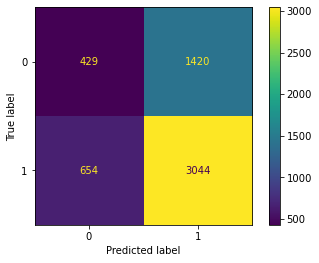


Precision: 0.68

Recall: 0.82

Accuracy: 0.63

F1 Score: 0.75

---------------------------------------------

ROC Score


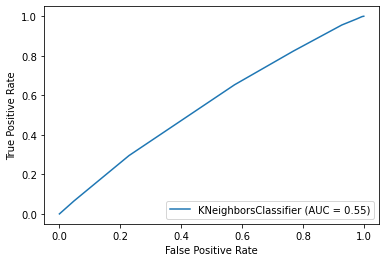


---------------------------------------------

AUC Score


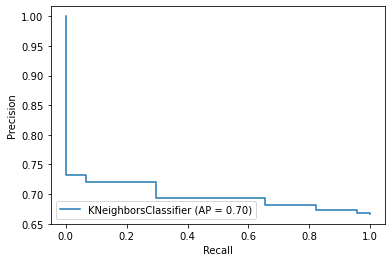


---------------------------------------------

K-Fold Cross Validation

Cross Validation accuracy score:  0.6288694003318321


In [3]:
print("Confusion Matrix")
skmet.plot_confusion_matrix(knn, predictors_test, target_test)
plt.show()
print("\nPrecision:", str(round(skmet.precision_score(target_test, knn_predictions), 2)))
print("\nRecall:", str(round(skmet.recall_score(target_test, knn_predictions), 2)))
print("\nAccuracy:", str(round(skmet.accuracy_score(target_test, knn_predictions), 2)))
print("\nF1 Score:", str(round(skmet.f1_score(target_test, knn_predictions), 2)))
print("\n---------------------------------------------")
print("\nROC Score")
skmet.plot_roc_curve(knn, predictors_test, target_test)
plt.show()
print("\n---------------------------------------------")
print("\nAUC Score")
skmet.plot_precision_recall_curve(knn, predictors_test, target_test)
plt.show()
print("\n---------------------------------------------")
print("\nK-Fold Cross Validation")
#Split the data into 5 folds, and compute the accuracy score 5 times, one for each possible test fold
folds = 5
avg_accuracy = np.empty(5)
kf = skmod.KFold()
count = 0
for i, j in kf.split(predictors):
    xtrain, xtest = predictors[i], predictors[j]
    ytrain, ytest = target[i], target[j]
    knn = KNeighborsClassifier(n_neighbors = 7)
    knn.fit(xtrain, ytrain)
    knn_predictions = knn.predict(xtest)
    avg_accuracy[count] = skmet.accuracy_score(ytest, knn_predictions)
    count = count + 1
print("\nCross Validation accuracy score: ", np.average(avg_accuracy)) #Print average accuracy score

# Clustering
### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Original Model

Text(0, 0.5, 'Graduation Rate')

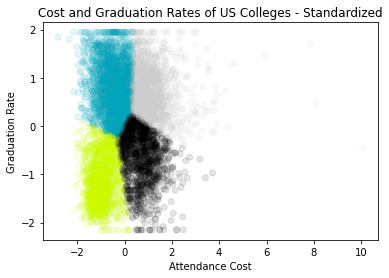

In [4]:
#Import College Scorecard dataset 
pd.set_option('display.max_columns', None)
df = pd.read_csv('CollegeScorecard.csv')
df = df[['UNITID', 'NPT4_048_PUB', 'NPT4_048_PRIV', 'C150_4', 'C150_L4']] #Only keep columns UNITID, tuition, and graduation rate
df = df.astype('float64')
df.set_index('UNITID', inplace = True)
df.dropna(thresh = 2, axis = 0, inplace = True)

#The pairs of columns NPT4_048_PUB + NPT4_048_PRIV, and C150_4 + C150_L4 are mutually exclusive
#Each pair is combined to make the variables AttendanceCost and GraduationRate respectively
df.fillna(0, inplace = True)
df['AttendanceCost'] = df['NPT4_048_PUB'] + df['NPT4_048_PRIV']
df['GraduationRate'] = df['C150_4'] + df['C150_L4']
df.drop(['NPT4_048_PUB', 'NPT4_048_PRIV', 'C150_4', 'C150_L4'], inplace = True, axis = 1)

#Standardize the data
df = (df - df.mean()) / (df.std())

#K-means algorithm is used to split the data into four groups, plotted below
kmeans = KMeans(n_clusters = 4, algorithm = 'elkan')
kmeans.fit(df)
cluster_kmeans = kmeans.predict(df)
attendance_cost = df['AttendanceCost'].values.reshape(-1, 1)
graduation_rate = df['GraduationRate'].values.reshape(-1, 1)
plt.scatter(attendance_cost, graduation_rate, c = cluster_kmeans, cmap = 'nipy_spectral', alpha = 0.1)
plt.title('Cost and Graduation Rates of US Colleges - Standardized')
plt.xlabel('Attendance Cost')
plt.ylabel('Graduation Rate')

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Diagnostics

In [ ]:
#Find the sum of squared distance for clusters when the data is split into up to 6 clusters
range_clusters = [1, 2, 3, 4, 5, 6]
avg_distance = []
for i in range_clusters:
    clusterer = KMeans(n_clusters = i).fit(df)
    avg_distance.append(clusterer.inertia_)
plt.plot(range_clusters, avg_distance)
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Distance")
plt.title("Optimal Clustering by Point Distance from Centroid")
plt.show()

# Analysis

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Classification Model

The classification model in ACA2 was constructed using data about circumstances in a classroom, such as activity type and number of transitions between activities.  The model was designed to predict on-task behaviour.

The confusion matrix shows that the model predicts on-task behaviour better than it predicts off-task behaviour.  Additionally, it is limited by a high probability of a false positive.  The precision and recall measures show that the model is fairly good at recalling data points that have already been fed into the model, but is not as good at predicting on-task behaviour for new data points.  The ROC score similarly shows that the model is only marginally better than random chance at predicting on-task behaviour.  Finally, the k-fold accuracy score is equivalent to the original accuracy score, suggesting that the poor performance of the model is not due to issues with splitting the dataset into test and train groups.

### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Clustering Model

The clustering model in ACA3 was constructed to divide a list of colleges along two metrics: cost and graduation rate.  Given this goal, it was appropriate for the data to be split into four groups.  The sum of squared distance plot supports this decision, as the average distance from points to the centroid of the cluster is relatively low.  However, using the elbow method, the optimal number of clusters is three.

Given the goal of my analysis, it was more appropriate to use four clusters than three.